# Word embeddings and logistic regression

These two topics are not inherently related. But we're going to create a connection between them, by using word vectors to create features for a logistic regression model.

To start with, we need to load a slightly larger spaCy model than we used last time.

You may need to change ```python3.7``` to ```python``` or ```python3``` to get this to work.

In [81]:
!python3.7 -m spacy download en_core_web_md

     |████████████████████████████████| 47.1 MB 17.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [1]:
import spacy, glob
from spacy.lang.en import STOP_WORDS
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import en_core_web_md
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
engl_nlp = en_core_web_md.load()

In [3]:
test = "I went back to the store, where I found they store their apples in the back."
doc = engl_nlp(test)

### Looking at an "embedding"

What actually is it?

In [4]:
print(doc[5].text)
doc[5].vector

store


array([ 4.0443e-01,  2.5853e-02, -2.8242e-01,  1.3591e-01,  5.3162e-01,
        3.5558e-01, -4.4101e-02, -2.6730e-01,  2.4868e-01,  1.6698e+00,
       -3.2510e-01,  1.0311e-01, -5.0500e-03, -4.7872e-01, -1.2018e-01,
        3.1490e-01, -3.2897e-01,  1.8736e+00,  4.9632e-01,  2.2269e-03,
       -4.0535e-01,  2.8639e-01,  9.7010e-04,  4.2422e-02, -2.3239e-01,
        1.4898e-01, -5.9861e-01, -3.1481e-01, -2.4008e-01,  1.3169e-02,
       -3.9922e-01, -1.5233e-01,  3.3129e-01,  1.8193e-01, -5.3594e-01,
        9.4763e-02,  3.1362e-01,  4.1929e-01,  5.5817e-02,  3.9787e-02,
       -3.2780e-01,  1.9989e-01,  5.2690e-01, -2.6164e-01, -3.0180e-01,
        3.0391e-01, -4.4413e-01, -4.0429e-01, -3.8054e-02,  1.5618e-01,
        9.8548e-02,  1.2965e-01,  8.9805e-01,  6.8168e-01,  5.4625e-01,
       -7.8904e-01, -2.1791e-01, -3.7487e-01, -1.2188e-02, -4.4032e-01,
        4.8587e-01, -4.9302e-01, -2.4821e-01,  1.7988e-01,  3.3138e-01,
       -2.6030e-01,  1.7261e-01,  3.1434e-01,  5.4501e-01,  4.93

**SpaCy's embeddings are static rather than contextual.**

One of these stores is a noun, and the other a verb. They shouldn't really be identical, and they won't be when we get to "contextualized" embeddings.

In [5]:
print(doc[5].text, doc[11].text)
cosine(doc[5].vector, doc[11].vector)

store store


0.0

### 1. Exploring and visualizing word embeddings

Given a list of words, it's not hard to turn them into a data frame where each row represents an embedding.

In [6]:
vocab = ['apple', 'banana', 'cat', 'dog', 'fish', 'octopus', 'mountain',
         'river', 'speak', 'run', 'shudder', 'in', 'out', 'love', 'hate']

In [7]:
vectordict = dict()
for v in vocab:
    doc = engl_nlp(v)
    vectordict[v] = doc[0].vector

In [8]:
vectordf = pd.DataFrame.from_dict(vectordict, orient = 'index')
vectordf

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
apple,-0.363910,0.437710,-0.204470,-0.228890,-0.142270,0.273960,-0.011435,-0.185780,0.373610,0.753390,...,-0.677310,0.280900,-0.517700,-0.410980,-0.412920,-0.067856,-0.033721,-0.729580,-0.478910,0.729560
banana,0.202280,-0.076618,0.370320,0.032845,-0.419570,0.072069,-0.374760,0.057460,-0.012401,0.529490,...,0.170570,0.366850,0.002525,-0.640090,-0.297650,0.789430,0.331680,-1.196600,-0.047156,0.531750
cat,-0.150670,-0.024468,-0.233680,-0.233780,-0.183820,0.327110,-0.220840,-0.287770,0.127590,1.165600,...,-0.331810,-0.109020,-0.023324,0.210600,-0.296330,0.815060,0.038524,0.460040,0.171870,-0.298040
dog,-0.401760,0.370570,0.021281,-0.341250,0.049538,0.294400,-0.173760,-0.279820,0.067622,2.169300,...,0.022908,-0.259290,-0.308620,0.001754,-0.189620,0.547890,0.311940,0.246930,0.299290,-0.074861
fish,-0.396710,-0.372360,-0.055794,0.071283,0.082012,0.672970,-0.551350,0.093016,-0.090448,1.742100,...,-0.231210,-0.389390,-0.776320,-0.238190,-0.101480,0.524810,-0.434280,-0.493160,0.228060,-0.464670
octopus,-0.091032,-0.789440,0.335180,0.269630,-0.332700,-0.028616,-0.546650,0.108790,0.071888,0.041089,...,0.049008,-0.099616,-0.501780,0.202700,0.034787,0.248630,-0.121850,-0.031629,0.579100,-0.076863
mountain,0.464630,0.102960,-0.171300,-0.718780,0.269900,0.606360,0.071690,0.710450,-0.627470,2.118600,...,-0.284770,0.207710,-0.039287,-0.065834,-0.464540,-0.055423,0.808050,0.639210,0.089043,-0.294910
river,0.096865,-0.290630,-0.220770,-0.780660,0.451750,0.923940,-0.565470,0.310980,-0.520390,2.432300,...,-0.333290,-0.192210,-0.600980,-0.392950,-0.067076,0.021785,-0.323220,-0.203230,-0.395790,-0.601690
speak,-0.210720,0.194310,-0.321450,0.499840,0.611310,-0.234940,0.156100,-0.267960,-0.383230,3.139700,...,0.176900,-0.275470,-0.346260,-0.029795,0.102970,0.268720,0.028883,0.171640,0.260060,0.173730
run,0.160730,-0.124740,0.117250,0.141430,-0.099597,0.213870,-0.144730,0.305320,0.730920,2.411800,...,-0.286640,-0.163650,0.135870,0.138270,-0.274430,-0.397010,0.445470,-0.078766,0.063416,-0.255440


#### Using principal component analysis to visualize a semantic space

Whenever we have a high-dimensional matrix like the one above, it's possible to use dimension-reduction techniques to flatten it into a plane (with some loss of information).

In [9]:
def vocab2pca(vocab):
    
    vectordict = dict()        # create a df of embeddings
    for v in vocab:
        doc = engl_nlp(v)
        vectordict[v] = doc[0].vector
        
    vectordf = pd.DataFrame.from_dict(vectordict, orient = 'index')
    
    vectorlengths = np.linalg.norm(vectordf, ord = 2, axis = 1)   # normalize vector lengths
    vectordf = vectordf.divide(vectorlengths, axis = 'rows')      # for PCA
    
    pca = PCA(n_components = 2)       
    components = pca.fit_transform(vectordf)                      # perform PCA
    plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1]}, index = vocab)
    
    return plotframe

In [10]:
plotframe = vocab2pca(vocab)
plotframe

,x,y
apple,0.282029,-0.184519
banana,0.389547,-0.269043
cat,0.289056,-0.079112
dog,0.186152,0.010265
fish,0.447778,0.112704
octopus,0.554031,-0.229215
mountain,0.078038,0.461860
river,0.139141,0.555447
speak,-0.479929,-0.105931
run,-0.296665,0.284954


In [11]:
def plot_the_frame(plotframe):    
    plt.figure(figsize = (10, 8))
    theplot = sns.scatterplot(x = plotframe.iloc[ : , 0], y = plotframe.iloc[ : , 1])
    collabels = plotframe.columns.tolist()
    theplot.set(xlabel = collabels[0], ylabel = collabels[1])

    for rownum in range(plotframe.shape[0]):
        x = plotframe.iloc[rownum, 0]
        y = plotframe.iloc[rownum, 1]
        theplot.text(x + 0.007, y + .007, 
        plotframe.index[rownum], horizontalalignment='left', 
        size='medium', color='black', weight='semibold')

    plt.show()

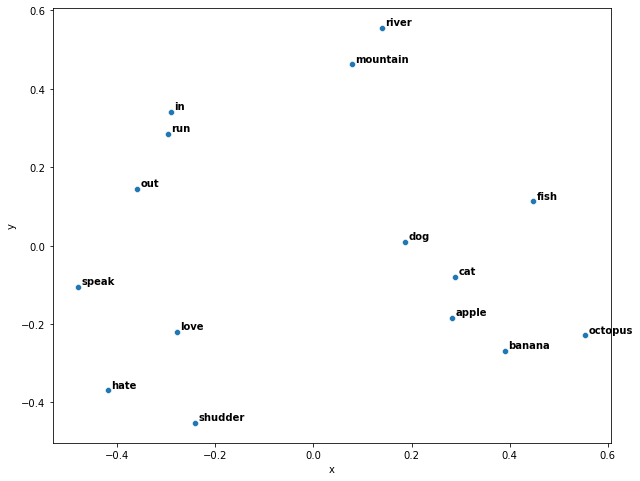

In [12]:
plot_the_frame(plotframe)

#### That was fun. Let's zoom in on the animals over on the noun side of things.

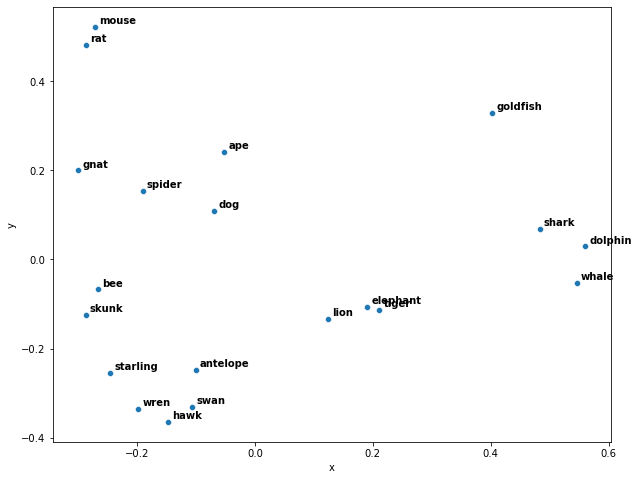

In [13]:
animals = ['starling', 'swan', 'hawk', 'dolphin', 'shark', 'whale', 'goldfish', 'lion', 'elephant', 
           'antelope', 'skunk', 'mouse', 'spider', 'gnat', 'ape', 'dog', 'rat', 'bee', 'tiger',
          'wren']
plotframe = vocab2pca(animals)
plot_the_frame(plotframe)

**Can we interpret this?**

There are certainly groups of animals visible here. How would you describe them?

But it's rarely easy to say what the *x* and *y* axes represent in a PCA plot.

However, we can create axes that are a little more interpretable if we like.

In [14]:
def get_vectors(wordlist): 
    vectors = []
    
    for ex in wordlist:        # for each word in a wordlist
        doc = engl_nlp(ex)
        vec = doc[0].vector    # get its vector
        vectorlength = np.linalg.norm(vec, ord = 2)     # normalize length
        vectors.append(vec / vectorlength)              # and save it in a list
        
    thesum = np.sum(vectors, axis = 0)                  # then add all the vectors
    vectorlength = np.linalg.norm(thesum, ord = 2)      # normalize length again
    
    return thesum / vectorlength

def make_direction(positive_examples, negative_examples):
    
    posvector = get_vectors(positive_examples)           # create a mean positive vector
    negvector = get_vectors(negative_examples)           # and negative vector
    direction = posvector - negvector                    # subtract the second from the first
    
    return direction
    

In [15]:
airvswater = make_direction(['fly', 'wings', 'air'], ['swim', 'fins', 'water'])
bigvslittle = make_direction(['big', 'huge', 'large'], ['small', 'tiny'])

Now, how do we use these two "directions" to organize a space?

We'll give each word an x position that is its cosine similarity to the first direction, and a y position that is its cosine similarity to the second.

In [16]:
def organizeby2dims(words, ref_vector1, ref_vector2, col1name, col2name):
    dict4df = dict()
    
    for colname in [col1name, col2name]:       # create a dictionary with 
        dict4df[colname] = []                  # appropriate key names
        
    for w in words:                            # for each word       
        doc = engl_nlp(w)
        vec = doc[0].vector
        cos1 = cosine(vec, ref_vector1)        # get its x position
        cos2 = cosine(vec, ref_vector2)        # and y position
        
        dict4df[col1name].append(cos1)
        dict4df[col2name].append(cos2)

    plotframe = pd.DataFrame(dict4df, index = words)  # make this a data frame,
                                                      # with words as index labels
    
    return plotframe

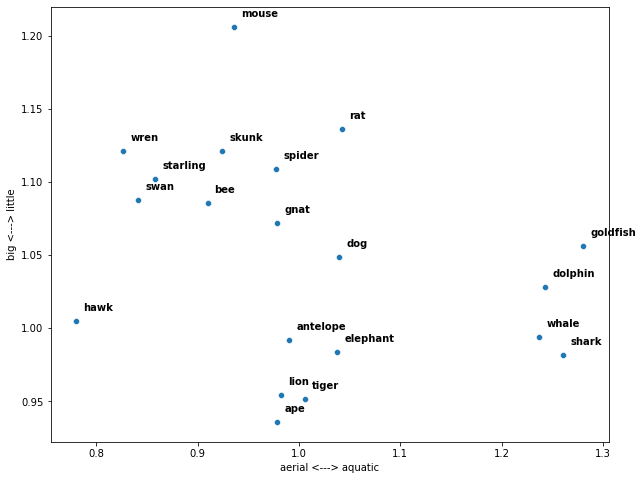

In [17]:
plotframe = organizeby2dims(animals, airvswater, bigvslittle, 'aerial <---> aquatic', 'big <---> little')
plot_the_frame(plotframe)

### 2. Explore an example on your own

Animals (other than hominids) aren't too controversial. Let's consider an example where all kinds of questions about social bias will immediately become obvious.

Here's a list of occupations. Try organizing them along axes like

1. wealthy vs needy
2. famous vs obscure
3. man vs woman
4. You can also fuse 1 & 2: rich and famous vs poor and obscure

Sometimes it helps to invent multiple synonyms for an idea to make sure you get the core idea you're shooting for. (E.g., by itself "rich" could mean, "and creamy, as in a dessert.")

In [18]:
occupations = ['farmer', 'surgeon', 'policeman', 'lawyer', 'actor', 'nurse', 
         'thief', 'politician', 'accountant', 'engineer', 'chef', 'teacher',
              'banker', 'dancer', 'bodyguard', 'pilot', 'actress', 'soldier', 
               'writer', 'artist', 'handyman', 'broker', 'queen']

### 3. Logistic regression using embeddings as features

Logistic regression is the go-to workhorse of supervised machine learning. There have long been fancier ways of modeling categories, but people still very commonly use logistic regression. It's often 98% as accurate as a more complex algorithm, and three times as simple to implement.

Let's see how it performs on the sentiment analysis task we undertook back in February.

In [19]:
negative_dir = '../../data/review_polarity/txt_sentoken/neg'
positive_dir = '../../data/review_polarity/txt_sentoken/pos'
neg_paths = glob.glob(f'{negative_dir}/*.txt')
pos_paths = glob.glob(f'{positive_dir}/*.txt')

all_paths = neg_paths + pos_paths      # notice the order
titles = [Path(text).stem for text in all_paths]

y = [0] * 1000 + [1] * 1000

In [20]:
count_vectorizer = CountVectorizer(input = 'filename',   # notice that we're now setting this up
                                  max_features = 5000)   # to automatically read a list of paths
                                                       # and also only taking the top 5000 words
    
word_counts = count_vectorizer.fit_transform(all_paths)  # that line does all the work!

titles = [Path(text).stem for text in all_paths]
count_df = pd.DataFrame(word_counts.toarray(), index = titles, 
                      columns = count_vectorizer.get_feature_names())

count_df.head()

,000,10,100,11,12,13,13th,14,15,16,...,young,younger,your,yourself,youth,zane,zany,zero,zeta,zone
cv676_22202,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
cv839_22807,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
cv155_7845,0,0,0,0,0,1,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
cv465_23401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cv398_17047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
for alpha in range(1, 8):
    bayes = MultinomialNB(alpha = alpha)
    cv_results = cross_validate(bayes, count_df, y, cv = 5)
    mean_score = np.mean(cv_results['test_score'])
    print(alpha, mean_score)

1 0.8125
2 0.8130000000000001
3 0.8135
4 0.8135
5 0.8115
6 0.8105
7 0.8119999999999999


In reality we could probably do better than this if we optimized the number of features. 5000 was an arbitrary choice.

#### Converting documents into embedding vectors

The loop below is slow; it could easily take 15 minutes on your machine. So you might want to skip it and just read in the file I've provided in the data folder. But I left the code here to show you the logic of what we're doing.

In [22]:
def get_vector(apath):
    
    with open(apath, encoding = 'utf-8') as f:
        filestring = f.read()
    doc = engl_nlp(filestring)
    
    vector = np.zeros(300)
    
    for token in doc:
        if (token.text not in STOP_WORDS):
            vector = vector + token.vector
            
    vectorlength = np.linalg.norm(vector, ord = 2)
    vector = vector / vectorlength
    
    return vector

dict4df = dict()

for apath, atitle in zip(all_paths, titles):
    vector = get_vector(apath)
    dict4df[atitle] = vector

X = pd.DataFrame.from_dict(dict4df, orient = 'index')
X

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
cv676_22202,-0.037989,0.050811,-0.037851,-0.032907,0.019423,0.032638,0.009293,-0.064114,0.001982,0.651753,...,-0.038224,0.009645,-0.012552,0.007518,0.004820,0.021401,0.000337,-0.025868,-0.022038,0.001314
cv839_22807,-0.024179,0.054244,-0.032737,-0.033261,0.013656,0.016853,-0.001686,-0.049685,-0.008903,0.684099,...,-0.043339,0.015395,-0.009792,0.012404,-0.003580,0.011981,-0.007913,-0.004395,-0.020773,-0.006906
cv155_7845,-0.044780,0.065446,-0.044724,-0.019240,0.021360,0.023025,0.007986,-0.074105,0.000032,0.665104,...,-0.046919,0.013847,-0.008657,0.010407,-0.008411,0.031178,-0.017981,-0.013611,-0.027558,-0.002668
cv465_23401,-0.029059,0.063753,-0.028900,-0.021443,0.030757,0.019688,0.032118,-0.040445,-0.007049,0.687947,...,-0.019229,0.028122,-0.028005,0.026461,0.005548,0.016820,0.004194,-0.011116,-0.034993,-0.015361
cv398_17047,-0.008542,0.068686,-0.045393,-0.036477,0.035862,0.035817,0.004053,-0.053109,-0.016162,0.663265,...,-0.029361,0.019659,-0.017542,0.013987,0.006681,0.005276,-0.002749,-0.002135,-0.026867,-0.001406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cv588_13008,-0.041881,0.060142,-0.027201,-0.039926,0.019555,0.018963,0.019520,-0.068060,0.018205,0.641562,...,0.008447,0.005257,-0.031494,0.027289,0.015501,0.022126,-0.002641,-0.039926,-0.032298,-0.009907
cv734_21568,-0.026643,0.073050,-0.027204,-0.012675,0.034382,0.040108,0.018890,-0.037171,-0.007049,0.672817,...,-0.021342,0.017626,-0.031007,0.018724,0.013919,0.027536,0.005618,-0.017313,-0.023364,0.000108
cv491_12145,-0.007460,0.060054,-0.040614,-0.030642,0.040954,0.017751,0.017945,-0.053777,-0.000708,0.666693,...,-0.035937,0.002543,-0.013119,0.023810,-0.006387,0.015990,-0.000020,-0.016064,-0.030189,-0.010568
cv647_13691,-0.031001,0.058376,-0.010892,-0.034052,0.009066,0.030369,0.008321,-0.037125,0.005631,0.703294,...,-0.050615,0.006125,-0.022141,0.029904,0.012732,0.017665,0.007533,-0.022417,-0.026352,0.001172


In [23]:
X.to_csv('review_sent_embeddings.tsv', index_label = 'filename', sep = '\t', header = False)

#### If you skipped that loop, pick up the thread here:

just read in the same file.

In [24]:
X = pd.read_csv('../../data/review_sent_embeddings.tsv', sep = '\t', index_col = 0, header = None)
X.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
cv676_22202,-0.037989,0.050811,-0.037851,-0.032907,0.019423,0.032638,0.009293,-0.064114,0.001982,0.651753,...,-0.038224,0.009645,-0.012552,0.007518,0.004820,0.021401,0.000337,-0.025868,-0.022038,0.001314
cv839_22807,-0.024179,0.054244,-0.032737,-0.033261,0.013656,0.016853,-0.001686,-0.049685,-0.008903,0.684099,...,-0.043339,0.015395,-0.009792,0.012404,-0.003580,0.011981,-0.007913,-0.004395,-0.020773,-0.006906
cv155_7845,-0.044780,0.065446,-0.044724,-0.019240,0.021360,0.023025,0.007986,-0.074105,0.000032,0.665104,...,-0.046919,0.013847,-0.008657,0.010407,-0.008411,0.031178,-0.017981,-0.013611,-0.027558,-0.002668
cv465_23401,-0.029059,0.063753,-0.028900,-0.021443,0.030757,0.019688,0.032118,-0.040445,-0.007049,0.687947,...,-0.019229,0.028122,-0.028005,0.026461,0.005548,0.016820,0.004194,-0.011116,-0.034993,-0.015361
cv398_17047,-0.008542,0.068686,-0.045393,-0.036477,0.035862,0.035817,0.004053,-0.053109,-0.016162,0.663265,...,-0.029361,0.019659,-0.017542,0.013987,0.006681,0.005276,-0.002749,-0.002135,-0.026867,-0.001406


It's almost always helpful to "scale" data before doing logistic regression; this spreads the regularization more evenly across the variables.

Note that really, technically, to avoid any overfitting, we should learn the scaling from our training set each time we do a "fold" of cross-validation, and apply a different scaler to the test set each time. This can be done in sklearn, but you need to use a "pipeline" and it's complicated. Also, the effects here are probably rather small, because we only have 300 features; it's not a very sparse feature space.

In [25]:
scaler = StandardScaler()
X_normed = scaler.fit_transform(X)

In [26]:
for c_param in [10, 1, .1, .02, .01, .005, .001, .0001]:
    logreg = LogisticRegression(C = c_param, max_iter = 1000)
    cv_results = cross_validate(logreg, X_normed, y, cv = 5)
    mean_score = np.mean(cv_results['test_score'])
    print(c_param, mean_score)

10 0.8045
1 0.8089999999999999
0.1 0.8185
0.02 0.8230000000000001
0.01 0.8285
0.005 0.827
0.001 0.8024999999999999
0.0001 0.7505


So here we get a ~1.5% improvement over the Naive Bayes wordcount strategy. Not huge, but it's something.

It's not necessarily always true that logistic regression will outperform Naive Bayes, and not always true that word embeddings improve a model, either. Word embeddings help most when data is *sparse.* For instance if there are many negative words that could be used about a movie ("exhaustingly," "tepid," "regrettable," etc), and your training set might not have examples of all of them, the embeddings will *compress* the data in a way that ensures you capture the shared "yuck" dimension.

**With this in mind, play around with the ```cv``` parameter of the two loops above.** This controls the number of splits ("folds") in the cross validation you're performing. Try setting it as low as 2, or as high as 10. How does this change the gap between Naive Bayes on word counts and logistic regression on word embeddings? It's a small effect and we can't be certain it's significant. But be trustful and go with the apparent pattern for a moment: why would you speculate we see this effect?

If we still have time after explaining that, we might vary the number of features we allow the CountVectorizer to produce, and see how much that affects results.